In [1]:
from matplotlib import pyplot as plt
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torchaudio
import torchaudio.functional as taF
from torch.utils.data import TensorDataset, DataLoader
import scipy
from scipy.io import wavfile

import os

In [2]:
wav_fname = 'MIR-1K/MIR-1K/Wavfile/abjones_1_01.wav'

In [3]:
samplerate, data = wavfile.read(wav_fname)

In [4]:
samplerate

16000

In [5]:
samples, original_rate = torchaudio.load(wav_fname)

In [6]:
original_rate

16000

In [7]:
samples.shape

torch.Size([2, 185856])

In [8]:
samples[1]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0024, 0.0034, 0.0034])

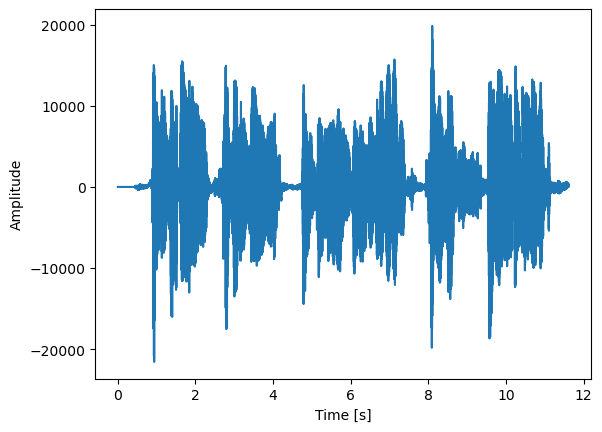

In [9]:
length = data.shape[0] / samplerate
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data[:, 1], label="Right channel")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [10]:
# TO-DO: pre-process according to paper https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8683024
vocal = data[:, 1]

In [11]:
vocal

array([  0,   0,   0, ...,  78, 110, 110], dtype=int16)

In [2]:
def extract_melspectrogram(audio_path, window_size=1024, hop_size=160, n_mels=229):
    samples, samplerate = torchaudio.load(audio_path)
    vocals = samples[1]

    melspecgram = torchaudio.transforms.MelSpectrogram(sample_rate=samplerate, 
                                                       n_fft=window_size, 
                                                       win_length=window_size, 
                                                       hop_length=hop_size, 
                                                       n_mels=n_mels, 
                                                       normalized=True)(vocals).squeeze()
    return melspecgram

In [13]:
melspec = extract_melspectrogram(wav_fname)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (229) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [14]:
def plot_spectrogram(specgram):
    fig, ax = plt.subplots()
    img = ax.imshow(specgram, aspect='auto', origin='lower')
    fig.colorbar(img)
    ax.set_xlabel('frames')
    ax.set_ylabel('mel bands')
    plt.show()

In [15]:
dB_spec = taF.amplitude_to_DB(melspec, multiplier=10, amin=1e-8, db_multiplier=melspec.max().log10())

In [16]:
dB_spec.shape

torch.Size([229, 1162])

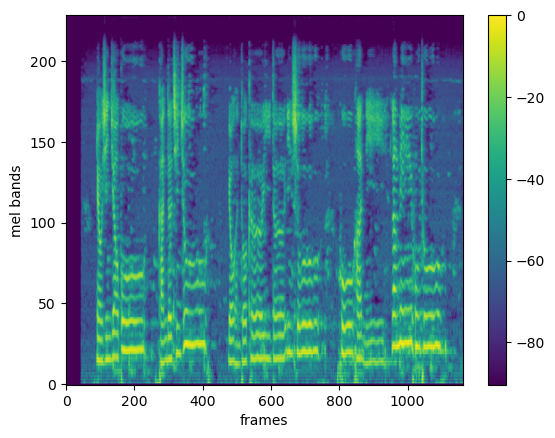

In [17]:
plot_spectrogram(dB_spec)

In [78]:
mel_spect.shape

(229, 1162)

In [8]:
"""
All songs were sampled at 44.1 kHz, and we used an STFT with
a Hann window of 2048 points and a shifting interval of 441 points
(10 ms) for calculating magnitude spectrograms, which we normalized to make the maximum value 1. 
"""
mag_spectrogram = np.abs(librosa.stft(vocal.astype(float), window=scipy.signal.windows.hann, win_length=1024, hop_length=160))
mag_spectrogram_norm = librosa.util.normalize(mag_spectrogram)

In [9]:
mag_spectrogram.shape

(1025, 1162)

In [74]:
mag_spectrogram_norm.max()

1.0

In [11]:
"""
Since a tempo determines note values, which would be difficult to correctly estimate 
for the proposed method without any mechanism to estimate tempos, 
all songs were modified to a BPM of 150 using a phase vocoder for the training, validation, and test data. 
"""
# onset_env = librosa.onset.onset_strength(y=vocal.astype(float), sr=samplerate)
# tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=samplerate)
# librosa.phase_vocoder(mag_spectrogram_norm, rate=150/tempo)

'\nSince a tempo determines note values, which would be difficult to correctly estimate \nfor the proposed method without any mechanism to estimate tempos, \nall songs were modified to a BPM of 150 using a phase vocoder for the training, validation, and test data. \n'

In [12]:
mag_spectrogram_norm.shape

(1025, 1162)

In [13]:
"""
We standardized the spectrograms for each frequency bin, 
and then calculated the mel-scale spectrograms with 229 channels.
"""
mel_spect = librosa.feature.melspectrogram(S=mag_spectrogram_norm.astype(float), 
                                           n_mels=229, 
                                           hop_length=160, win_length=1024,)

# mel_spect = librosa.feature.melspectrogram(y=vocal.astype(float), sr=samplerate, 
#                                            n_mels=229, 
#                                            hop_length=160, win_length=1024,)

In [3]:
files = os.listdir('MIR-1K/MIR-1K/Wavfile')

In [4]:
num_files = len(files)
n_mels = 229
num_frames = 1300
num_classes = 41

In [5]:
# TODO Implement CREPE pre-processing: https://github.com/marl/crepe/blob/master/crepe/core.py
"""
Pitch labels are for every 20ms, but each melspec frame is 10ms.
We also bin pitches
"""
def pitch_to_frame(annotations, num_frames=2000, num_pitches=42):
    num_classes = num_pitches
    annotation_matrix = torch.zeros((num_frames, num_classes))
    note_range = list(librosa.midi_to_note([i for i in range(36 , 77)], cents=False))
    for idx, entry in enumerate(annotations): # iterate the annotations one by one
        # assign a value of 1 to all frames within the segment
        # print(note_range.index(entry))
        if entry in note_range:
            annotation_matrix[idx, note_range.index(entry)] = 1
        # print(annotation_matrix[1:10, 0])
    return annotation_matrix

def load_pitch_labels(file_path):
    pitch_label = np.loadtxt(file_path, dtype=float)
    
    # Convert semitone to discrete note value
    pitch_midi = librosa.midi_to_note(pitch_label)
    pitch_midi[pitch_midi=='C-1'] = 'NA'

    # Convert labels from 20ms frequency to 10ms (i.e. repeat twice)
    pitch_midi_labels = np.repeat(pitch_midi,2)
    return pitch_midi_labels
    
    
'''
 - Load the data, 
 - Extract mel spectrograms
 - Annotation: one element corresponding to one audio file
'''
data = torch.zeros((num_files, num_frames, n_mels)) # for storing mel spectrograms
labels = torch.zeros((num_files, num_frames, num_classes))

for i, file_id in enumerate(files[:5]):
    melspecgram = extract_melspectrogram(f"MIR-1K/MIR-1K/Wavfile/{file_id}", n_mels=n_mels)
    # the number of the melspectrograms' time frames vary from 4 to 13 seconds
    # for simplicity, set them all to exactly 1300 (max 13 seconds) time frames
    if(melspecgram.shape[1] < num_frames): # pad with zeros if necessary
        melspecgram = nnF.pad(melspecgram, (num_frames-melspecgram.shape[1], 0))
    data[i] = melspecgram.T[:num_frames] # truncate if necessary

    pitch_midi_labels = load_pitch_labels(f"MIR-1K/MIR-1K/PitchLabel/{file_id.split('.')[0]}.pv")
    annotation_matrix = pitch_to_frame(pitch_midi_labels, num_frames=num_frames, num_pitches=num_classes)
    labels[i] = annotation_matrix

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (229) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (229) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [6]:
data.shape

torch.Size([1000, 1300, 229])

In [7]:
labels.shape

torch.Size([1000, 1300, 41])

In [16]:
mel_spect = (mel_spect - np.mean(mel_spect)) / np.std(mel_spect)

In [75]:
mel_spect.max()

8.694262387598727

In [18]:
"""
We applied frame stacking [27] with a stack size of 5 and a skip
size of 1 to the mel-scale spectrograms, and added zero frames at the
both ends to align with soss and eoss. 
"""

'\nWe applied frame stacking [27] with a stack size of 5 and a skip\nsize of 1 to the mel-scale spectrograms, and added zero frames at the\nboth ends to align with sos\x04s and eos\x04s. \n'

In [19]:
mel_spect.shape

(229, 1162)

In [20]:
mel_spect.shape[0]

229

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [155]:
batch_size = 4
# TODO: Load the different splits into DataLoaders
train_loader = DataLoader(TensorDataset(data, labels), batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(TensorDataset(valid_data, valid_labels), batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

In [8]:
# TODO Implement CREPE archi: https://github.com/marl/crepe/blob/master/crepe/core.py

In [10]:
data.shape[-1]

229

In [9]:
# Initialize model
input_size = data.shape[-1]  # Number of features
hidden_size_enc = 300
hidden_size_dec = 200
output_size = 600  # Number of tokens in output (maximum file length for pitch labels)
model = Seq2Seq(input_size, hidden_size_enc, hidden_size_dec, output_size)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [10]:
model.apply(init_weights)

Seq2Seq(
  (encoder): EncoderRNN(
    (lstm): LSTM(229, 300, num_layers=2, dropout=0.2, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (lstm): LSTM(229, 200, dropout=0.2)
    (fc): Linear(in_features=200, out_features=600, bias=True)
  )
  (attention): Attention(
    (conv): Conv1d(300, 10, kernel_size=(100,), stride=(1,), padding=(50,))
    (fc): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [11]:
model

Seq2Seq(
  (encoder): EncoderRNN(
    (lstm): LSTM(229, 300, num_layers=2, dropout=0.2, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (lstm): LSTM(229, 200, dropout=0.2)
    (fc): Linear(in_features=200, out_features=600, bias=True)
  )
  (attention): Attention(
    (conv): Conv1d(300, 10, kernel_size=(100,), stride=(1,), padding=(50,))
    (fc): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [23]:
encoder = EncoderRNN(229, 10)

In [24]:
encoder

EncoderRNN(
  (lstm): LSTM(229, 10, num_layers=2, dropout=0.2, bidirectional=True)
)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
encoder = encoder.to(device)

In [11]:
data = data.to(device)

In [27]:
encoder_outputs, hidden, cell = encoder(data)

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.24 GiB. GPU 0 has a total capacity of 7.45 GiB of which 1.73 GiB is free. Including non-PyTorch memory, this process has 5.26 GiB memory in use. Of the allocated memory 1.25 GiB is allocated by PyTorch, and 2.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [ ]:
encoder = EncoderRNN(229, EMB_DIM, HIDDEN_DIM, N_LAYERS)
decoder = DecoderRNN(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, N_LAYERS)

src_seq = torch.randint(0, INPUT_DIM, (32, 10))  # batch of 32, sequence length 10
encoder_outputs, hidden, cell = encoder(src_seq)

input = torch.randint(0, OUTPUT_DIM, (32,))  # batch of 32, single time step
output, hidden, cell = decoder(input, encoder_outputs, hidden, cell)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
                             

# torch.nn.utils.clip_grad_value_(model.parameters(), 5.0)

"""
The batch size and the
number of epochs were 20 and 15. Pytorch v0.4.1 [30] was used for
implementation.
"""